## André Callil
## Revolut Data Science Assignment

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


In [2]:
# data loading
users = pd.read_csv('rev-users.csv', parse_dates=['created_date'])
devices = pd.read_csv('rev-devices.csv')
notifications = pd.read_csv('rev-notifications.csv', parse_dates=['created_date'])
transactions = pd.read_csv('rev-transactions.csv', parse_dates=['created_date'])


## Exploratory Analysis

### Users

In [3]:
users.head()


,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,0,0
1,user_1,1975,GB,London,2018-01-29 03:38:46.676876,0,STANDARD,NaN,NaN,21,0,0
2,user_2,1987,PL,Poznań,2018-01-18 19:17:31.229096,0,STANDARD,0.0,0.0,21,0,0
3,user_3,1994,FR,Paris,2018-01-15 18:47:56.723104,0,STANDARD,1.0,0.0,0,0,0
4,user_4,1985,GB,Beckenham,2018-01-11 00:36:46.673673,0,STANDARD,NaN,NaN,2,0,0


In [4]:
users.dtypes


user_id                                             object
birth_year                                           int64
country                                             object
city                                                object
created_date                                datetime64[ns]
user_settings_crypto_unlocked                        int64
plan                                                object
attributes_notifications_marketing_push            float64
attributes_notifications_marketing_email           float64
num_contacts                                         int64
num_referrals                                        int64
num_successful_referrals                             int64
dtype: object

In [5]:
# unique values on dataframe
users.nunique()


user_id                                     19430
birth_year                                     69
country                                        41
city                                         6049
created_date                                19430
user_settings_crypto_unlocked                   2
plan                                            6
attributes_notifications_marketing_push         2
attributes_notifications_marketing_email        2
num_contacts                                  302
num_referrals                                   1
num_successful_referrals                        1
dtype: int64

In [6]:
# users summary
users.describe()


,birth_year,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
count,19430.000000,19430.000000,12820.000000,12820.000000,19430.000000,19430.0,19430.0
mean,1983.648636,0.181009,0.947582,0.895944,17.887699,0.0,0.0
std,11.368871,0.385035,0.222877,0.305345,46.506438,0.0,0.0
min,1929.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,1978.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.0
50%,1986.000000,0.000000,1.000000,1.000000,5.000000,0.0,0.0
75%,1992.000000,0.000000,1.000000,1.000000,19.000000,0.0,0.0
max,2001.000000,1.000000,1.000000,1.000000,2918.000000,0.0,0.0


In [7]:
# users per country
users.country.value_counts()


GB    6315
PL    2306
FR    2110
IE    1214
RO    1096
ES     991
LT     646
PT     604
MT     548
DE     446
CH     443
CZ     355
IT     311
GR     218
CY     191
NL     174
LV     171
HU     157
BE     143
SE     141
DK     101
BG      94
SI      87
NO      87
SK      79
AT      78
HR      63
JE      55
GI      44
FI      38
EE      35
LU      24
GG      15
IM      11
GP      10
RE       7
IS       7
AU       6
LI       4
MQ       4
GF       1
Name: country, dtype: int64

In [8]:
# users per plan
users.plan.value_counts()


STANDARD         17992
PREMIUM            865
METAL              507
METAL_FREE          37
PREMIUM_OFFER       25
PREMIUM_FREE         4
Name: plan, dtype: int64

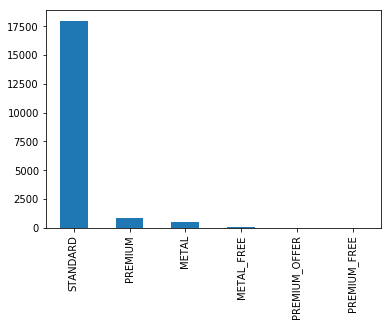

In [9]:
# users per plan chart
fig, ax = plt.subplots()
users['plan'].value_counts().plot(ax=ax, kind='bar')
plt.show()


In [10]:
# amount of contacts per user
users.num_contacts.value_counts()


0       6970
2        679
1        665
3        662
4        622
5        543
6        500
7        469
8        433
9        409
10       353
11       340
12       334
14       297
13       295
15       253
19       226
16       226
17       209
18       199
20       184
23       177
22       170
25       153
24       144
21       140
26       124
28       123
27       121
29       118
        ... 
291        1
419        1
435        1
563        1
196        1
212        1
244        1
276        1
404        1
420        1
1262       1
670        1
414        1
165        1
197        1
229        1
357        1
549        1
286        1
238        1
246        1
262        1
278        1
726        1
222        1
151        1
199        1
231        1
807        1
1071       1
Name: num_contacts, Length: 302, dtype: int64

In [11]:
# data from 19430 different users 
# gb dominates as main country (32%), follow by poland and france
# users are spread in 41 different countries in 6049 different cities
# standard plan accounts for 93% of users
# avg birth year is 1983 (36 years old), std=11 (68% are btw 25-47 years old)
# only about 18% of users have unlocked crypto
# in regards to notifications, only 12820 users have known data out of 19430
# about 95% of users with data available (12820/19430) have marketing notifications on phone
# about 90% of users with data available (12820/19430) have marketing notifications on email
# avg number of contacts each user have is 18, with a max of 2918 and 6970 having 0 contacts
# referrals is not useful information since it's all 0's


### Devices

In [12]:
devices.head()


,brand,user_id
0,Android,user_3257
1,Apple,user_6809
2,Android,user_9144
3,Apple,user_3636
4,Android,user_5970


In [13]:
# amount of users using android, apple and other devices
devices.brand.value_counts()


Android    9714
Apple      9673
Unknown      43
Name: brand, dtype: int64

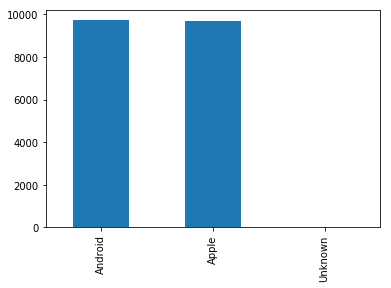

In [14]:
# amount of users using android, apple and other devices chart
fig, ax = plt.subplots()
devices['brand'].value_counts().plot(ax=ax, kind='bar')
plt.show()


### Notifications

In [15]:
notifications.head()


,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4151,2018-12-04 02:57:56.425660
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_1408,2018-12-11 02:04:46.284683
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6292,2018-12-14 17:09:58.900808


In [16]:
# notifications summary
notifications.describe()


,reason,channel,status,user_id,created_date
count,121813,121813,121813,121813,121813
unique,17,3,2,18953,121810
top,REENGAGEMENT_ACTIVE_FUNDS,EMAIL,SENT,user_5133,2018-07-15 16:27:12.192706
freq,35844,61253,89477,289,2
first,NaN,NaN,NaN,NaN,2018-01-10 12:09:55.050139
last,NaN,NaN,NaN,NaN,2019-05-12 17:12:14.132130


In [17]:
# frequency of notification types
notifications['reason'].value_counts()


REENGAGEMENT_ACTIVE_FUNDS               35844
FIFTH_PAYMENT_PROMO                     23743
NO_INITIAL_CARD_USE                     11221
NO_INITIAL_CARD_ORDER                   11136
METAL_GAME_START                         8373
LOST_CARD_ORDER                          6146
NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER     5459
JOINING_ANNIVERSARY                      4158
MADE_MONEY_REQUEST_NOT_SPLIT_BILL        3506
ONBOARDING_TIPS_ACTIVATED_USERS          3145
ENGAGEMENT_SPLIT_BILL_RESTAURANT         2298
BLACK_FRIDAY                             2109
METAL_RESERVE_PLAN                       1233
PREMIUM_ENGAGEMENT_INACTIVE_CARD         1124
WELCOME_HOME                              950
PUMPKIN_PAYMENT_NOTIFICATION              690
PREMIUM_ENGAGEMENT_FEES_SAVED             678
Name: reason, dtype: int64

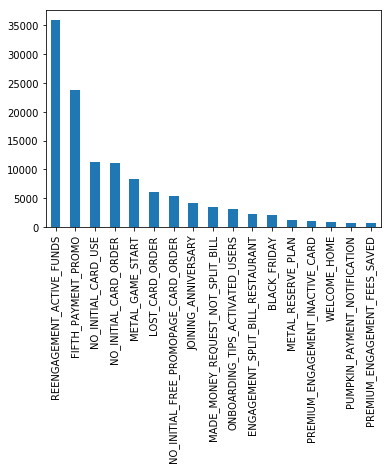

In [18]:
# frequency of notification types chart
fig, ax = plt.subplots()
notifications['reason'].value_counts().plot(ax=ax, kind='bar')
plt.show()


In [19]:
# notifications per user
users_nf = notifications['user_id'].value_counts()
users_nf.head()


user_5133     289
user_1047     177
user_8941     129
user_11007     88
user_13699     80
Name: user_id, dtype: int64

In [20]:
# notifications per user summary
users_nf.describe()


count    18953.000000
mean         6.427109
std          4.815286
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max        289.000000
Name: user_id, dtype: float64

In [21]:
# REENGAGEMENT_ACTIVE_FUNDS dominates as most received notification
# users avg 6 notifications, sd of 5 (68% of users from 1-11 notifications)
# find a way to plot distribution of notifications form users


### Transactions

In [22]:
transactions.head()


,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_898,2018-04-03 03:34:21.784487
1,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-19 06:15:59.537032
2,transaction_2,CARD_PAYMENT,AED,43.40,COMPLETED,FALSE,5814.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-18 18:53:41.323032
3,transaction_3,TRANSFER,AED,10043.01,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_1652,2019-03-22 14:20:01.513032
4,transaction_4,CARD_PAYMENT,AED,43.81,COMPLETED,FALSE,5651.0,Abu Dhabi,ARE,OUTBOUND,user_5509,2019-03-22 05:42:50.316652


In [23]:
transactions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740075 entries, 0 to 2740074
Data columns (total 12 columns):
transaction_id           object
transactions_type        object
transactions_currency    object
amount_usd               float64
transactions_state       object
ea_cardholderpresence    object
ea_merchant_mcc          float64
ea_merchant_city         object
ea_merchant_country      object
direction                object
user_id                  object
created_date             datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 250.9+ MB


In [24]:
# frequency of type of transactions
transactions['transactions_type'].value_counts()


CARD_PAYMENT    1475780
TRANSFER         500409
TOPUP            388331
EXCHANGE         159148
ATM               93675
CASHBACK          82789
FEE               23659
CARD_REFUND       11962
TAX                2829
REFUND             1493
Name: transactions_type, dtype: int64

In [25]:
# number of transcations per currency
transactions['transactions_currency'].value_counts()


EUR    1160135
GBP     887795
PLN     231583
RON     167806
USD      80639
CZK      44970
CHF      39716
SEK      26804
AUD      16871
NOK      14271
DKK      14058
CAD       8772
HUF       8408
TRY       4429
AED       3774
NZD       3727
ILS       3563
BTC       3327
JPY       3200
XRP       2932
ZAR       2897
SGD       2207
THB       2159
HKD       1818
ETH       1145
MAD        925
LTC        584
BCH        326
QAR        314
HRK        287
BGN        257
MXN        159
INR        148
RUB         58
SAR         11
Name: transactions_currency, dtype: int64

In [26]:
# transactions per user
users_ts = transactions['user_id'].value_counts()
users_ts.head()


user_12657    5285
user_4243     3381
user_10794    3223
user_1285     3056
user_10869    2913
Name: user_id, dtype: int64

In [27]:
# transactions per user summary
users_ts.describe()


count    18766.000000
mean       146.012736
std        245.809785
min          1.000000
25%         17.000000
50%         60.000000
75%        166.000000
max       5285.000000
Name: user_id, dtype: float64

In [28]:
# amount of transcations
len(transactions)


2740075

In [29]:
# card payment is the most common transaction type, followed by transfer, topup, exchange, atm and cashback
# eur and gbp dominates as main currencies
# data from 18766 different users on transactions
# users have an avg of 146 transactions, min 1, max 5285


### User Engagement Analysis

In [30]:
# user engagement measures whether users find value in a product
# in other words, the level of user envolvement with the product
# measure of user engagement: amount of transactions per period of time (activity)


In [31]:
# grouping transactions per user from first to last day
count = transactions[['transaction_id', 'user_id']].groupby('user_id').count().reset_index()
max_date = transactions[['created_date', 'user_id']].groupby('user_id').max().reset_index()
min_date = transactions[['created_date', 'user_id']].groupby('user_id').min().reset_index()


In [32]:
# labeling columns
count.columns = ['user_id', 'transactions']
min_date.columns = ['user_id', 'min_date']
max_date.columns = ['user_id', 'max_date']


In [33]:
# merging all together
merged_date = (min_date.merge(max_date, how='inner', on='user_id')).merge(count, how='inner', on='user_id')
delta_date = merged_date['max_date'] - merged_date['min_date']
merged_date['weeks_active'] = delta_date / np.timedelta64(7, 'D')
merged_date['engagement_score'] = merged_date['transactions'] / merged_date['weeks_active']
merged_date.head()


,user_id,min_date,max_date,transactions,weeks_active,engagement_score
0,user_0,2018-01-16 23:23:48.330466,2019-05-02 03:38:44.690466,389,67.168149,5.791435
1,user_1,2018-01-31 09:13:58.795876,2019-02-26 22:05:28.902876,129,55.933681,2.306303
2,user_10,2018-01-04 08:09:23.911282,2019-05-11 11:01:00.564282,1053,70.302739,14.978079
3,user_100,2018-01-15 16:39:14.747386,2019-05-07 13:00:24.319386,133,68.121147,1.952404
4,user_1000,2018-01-06 14:26:25.535706,2018-06-26 05:00:42.236706,39,24.372448,1.600168


In [34]:
# selecting features to merge dataframes
merged_date_new = merged_date[['user_id', 'engagement_score']]
users_new = users[['user_id', 'birth_year', 'country', 
                   'user_settings_crypto_unlocked', 
                   'plan', 'num_contacts']]


In [35]:
# merging dataframes on user_id
df_first = pd.merge(merged_date_new, users_new, on='user_id')
df = pd.merge(df_first, devices, on='user_id')


In [36]:
# removing extreme cases to prevent it from affecting the model
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


In [37]:
# removing outliers
df = remove_outlier(df, 'engagement_score')


In [38]:
# drop user_id
del df['user_id']


In [39]:
# adding age column
df['age'] = 2019 - df['birth_year']


In [40]:
# final dataframe for analysis
df.head()


,engagement_score,birth_year,country,user_settings_crypto_unlocked,plan,num_contacts,brand,age
0,5.791435,1989,PL,1,STANDARD,3,Apple,30
1,2.306303,1975,GB,0,STANDARD,21,Apple,44
2,14.978079,1980,FR,0,STANDARD,38,Apple,39
3,1.952404,1969,GB,0,STANDARD,0,Apple,50
4,1.600168,1960,GB,1,STANDARD,0,Android,59


In [41]:
# saving original dataframe
df_original = df


In [42]:
# converting country to numerical
countries = df.country.drop_duplicates().reset_index(drop=True)
countries = pd.DataFrame(countries)
countries['countries'] = countries.index.tolist()
countries


,country,countries
0,PL,0
1,GB,1
2,FR,2
3,LT,3
4,ES,4
5,CZ,5
6,DE,6
7,CH,7
8,IE,8
9,RO,9


In [43]:
# converting plan to numerical
plans = df.plan.drop_duplicates().reset_index(drop=True)
plans = pd.DataFrame(plans)
plans['plans'] = plans.index.tolist()
plans


,plan,plans
0,STANDARD,0
1,PREMIUM,1
2,METAL,2
3,METAL_FREE,3
4,PREMIUM_OFFER,4
5,PREMIUM_FREE,5


In [44]:
# converting brand to numerical
brands = df.brand.drop_duplicates().reset_index(drop=True)
brands = pd.DataFrame(brands)
brands['brands'] = brands.index.tolist()
brands


,brand,brands
0,Apple,0
1,Android,1
2,Unknown,2


In [45]:
df = pd.merge(df, countries, on='country')
df = pd.merge(df, plans, on='plan')
df = pd.merge(df, brands, on='brand')


In [46]:
# model dataframe with relevant features
df = df.drop(['country', 'plan', 'brand', 'birth_year'], axis=1)
df.head()


,engagement_score,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
0,5.791435,1,3,30,0,0,0
1,0.739598,0,0,31,0,0,0
2,2.022998,1,7,27,0,0,0
3,0.053889,0,0,48,0,0,0
4,0.481496,0,0,24,0,0,0


In [47]:
# dependent variable
df_y = df['engagement_score']
df_y.head()

0    5.791435
1    0.739598
2    2.022998
3    0.053889
4    0.481496
Name: engagement_score, dtype: float64

In [48]:
# independent variables
df_x = df.drop(['engagement_score'], axis=1)
df_x.head()


,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
0,1,3,30,0,0,0
1,0,0,31,0,0,0
2,1,7,27,0,0,0
3,0,0,48,0,0,0
4,0,0,24,0,0,0


In [49]:
# correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,engagement_score,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
engagement_score,1,0.085,0.083,-0.14,-0.0027,0.19,-0.022
user_settings_crypto_unlocked,0.085,1,0.016,-0.062,0.071,0.19,0.046
num_contacts,0.083,0.016,1,-0.02,0.12,0.041,-0.053
age,-0.14,-0.062,-0.02,1,0.0057,0.05,0.0023
countries,-0.0027,0.071,0.12,0.0057,1,0.022,0.038
plans,0.19,0.19,0.041,0.05,0.022,1,-0.05
brands,-0.022,0.046,-0.053,0.0023,0.038,-0.05,1


### Model

In [50]:
# XGBoost, hyperparameter tuning
gbm = xgb.XGBRegressor()
reg_cv = GridSearchCV(gbm, {'max_depth':[6,7,8], 
                            'n_estimators':[300,500,700]}, 
                      verbose=1, cv=3, n_jobs=-1)


In [51]:
# fitting the model on the data
reg_cv.fit(df_x, df_y)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   41.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [6, 7, 8], 'n_estimators': [300, 500, 700]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [52]:
# selecting best parameters
reg_cv.best_params_


{'max_depth': 6, 'n_estimators': 300}

In [53]:
# fitting the model with best parameters
gbm = xgb.XGBRegressor(**reg_cv.best_params_)
gbm.fit(df_x, df_y)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [54]:
# predicting outcome and checking mean value of user engagement score
predictions = gbm.predict(df_x)
np.mean(predictions)


3.5744236

In [55]:
# evaluating the model
rmse = np.sqrt(mean_squared_error(df_y, predictions))
print("RMSE: %f" % (rmse))


RMSE: 2.878471


In [56]:
# exploring crypto
df_x_crypto = df_x[df_x['user_settings_crypto_unlocked']==1]
df_x_crypto.head()


,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
0,1,3,30,0,0,0
2,1,7,27,0,0,0
12,1,0,26,0,0,0
15,1,3,26,0,0,0
39,1,35,27,0,0,0


In [57]:
# exploring contacts 
df_x_contacts = df_x[df_x['num_contacts']==55]
df_x_contacts.head()


,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
56,0,55,33,0,0,0
59,1,55,23,0,0,0
1019,0,55,25,1,0,0
1638,0,55,28,1,0,0
4291,0,55,28,2,0,0


In [58]:
# exploring age 
df_x_age = df_x[df_x['age']==25]
df_x_age.head()


,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
21,0,0,25,0,0,0
35,0,1,25,0,0,0
40,0,0,25,0,0,0
67,0,19,25,0,0,0
89,0,0,25,0,0,0


In [59]:
# exploring countries
df_x_country = df_x[df_x['countries']==24]
df_x_country.head()


,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
7197,0,6,33,24,0,0
7198,0,19,31,24,0,0
7199,0,0,51,24,0,0
7200,0,1,52,24,0,0
7201,1,0,35,24,0,0


In [60]:
# exploring plans 
df_x_plan = df_x[df_x['plans']==5]
df_x_plan.head()


,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
8082,0,22,41,0,5,0
16430,0,38,33,0,5,1
16431,0,7,34,4,5,1


In [61]:
# exploring devices brand 
df_x_device = df_x[df_x['brands']==0]
df_x_device.head()


,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
0,1,3,30,0,0,0
1,0,0,31,0,0,0
2,1,7,27,0,0,0
3,0,0,48,0,0,0
4,0,0,24,0,0,0


In [62]:
# playing with predictions from different data
predictions = gbm.predict(df_x_device)
np.mean(predictions)


3.664785

Mean:  3.574824323302589 
Median:  2.360590952145065


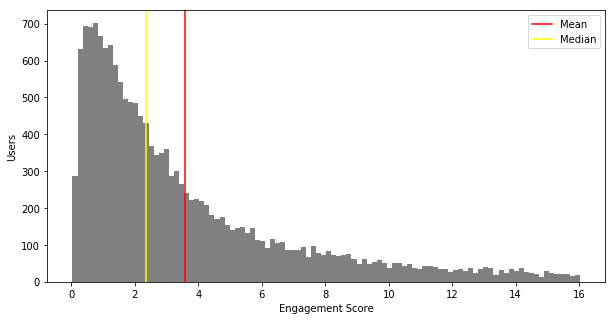

In [63]:
# engagement score distribution plot
engagement_score = df['engagement_score']

mean = engagement_score.mean()
median = engagement_score.median()

print('Mean: ',mean,'\nMedian: ',median)
plt.figure(figsize=(10,5))
plt.hist(engagement_score, bins=100, color='grey')
plt.axvline(mean, color='red', label='Mean')
plt.axvline(median, color='yellow', label='Median')
plt.xlabel('Engagement Score')
plt.ylabel('Users')
plt.legend()
plt.show()


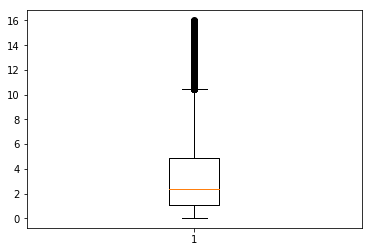

In [64]:
# engagement score boxplot
plt.boxplot(df['engagement_score'])
plt.show()


## Measuring effectiveness of churn rate reducement

In [65]:
# churn rate can be interpreted in many ways, such as: 
# (ues beginning of period - ues end of period) / ues beginning of period
# where ues = users engagement score
# let's say business strategies to reduce churn rate are implemented starting month y which follows month x
# one method would be to take average ues for month x and compare to y, and see how it changes


In [66]:
# implementantion
# filterting dates
transactions_1 = transactions[(transactions['created_date'] > '2019-01-01') & 
                              (transactions['created_date'] <= '2019-01-31')]
transactions_2 = transactions[(transactions['created_date'] > '2019-02-01') & 
                              (transactions['created_date'] <= '2019-02-28')]



In [67]:
len(transactions)

2740075

In [68]:
len(transactions_1)

263655

In [69]:
len(transactions_2)

278902

In [70]:
# month 1 data
# grouping transactions per user from first to last transaction of the month
month_1_count = transactions_1[['transaction_id', 'user_id']].groupby('user_id').count().reset_index()
month_1_max = transactions_1[['created_date', 'user_id']].groupby('user_id').max().reset_index()
month_1_min = transactions_1[['created_date', 'user_id']].groupby('user_id').min().reset_index()


In [71]:
# month 2 data
# grouping transactions per user from first to last transaction of the month
month_2_count = transactions_2[['transaction_id', 'user_id']].groupby('user_id').count().reset_index()
month_2_max = transactions_2[['created_date', 'user_id']].groupby('user_id').max().reset_index()
month_2_min = transactions_2[['created_date', 'user_id']].groupby('user_id').min().reset_index()


In [72]:
# labeling columns
month_1_count.columns = ['user_id', 'transactions']
month_1_min.columns = ['user_id', 'min_date']
month_1_max.columns = ['user_id', 'max_date']
month_2_count.columns = ['user_id', 'transactions']
month_2_min.columns = ['user_id', 'min_date']
month_2_max.columns = ['user_id', 'max_date']


In [73]:
# merging all together month 1
merged_date_1 = (month_1_min.merge(month_1_max, how='inner', on='user_id')).merge(month_1_count, 
                                                                                  how='inner', 
                                                                                  on='user_id')
delta_date_1 = merged_date_1['max_date'] - merged_date_1['min_date']
merged_date_1['weeks_active'] = delta_date_1 / np.timedelta64(7, 'D')
merged_date_1['engagement_score'] = merged_date_1['transactions'] / merged_date_1['weeks_active']
merged_date_1.head()


,user_id,min_date,max_date,transactions,weeks_active,engagement_score
0,user_0,2019-01-20 22:41:40.009466,2019-01-29 01:48:18.524466,7,1.161373,6.027348
1,user_1,2019-01-11 02:47:39.583876,2019-01-23 00:01:36.165876,4,1.697812,2.355974
2,user_10,2019-01-01 18:56:31.991282,2019-01-28 13:23:20.954282,99,3.824089,25.888520
3,user_100,2019-01-18 21:31:41.272386,2019-01-30 17:34:29.375386,7,1.690754,4.140164
4,user_10000,2019-01-06 22:24:17.148653,2019-01-21 18:37:24.243653,10,2.120349,4.716205


In [74]:
# merging all together month 2
merged_date_2 = (month_2_min.merge(month_2_max, how='inner', on='user_id')).merge(month_2_count, 
                                                                                  how='inner', 
                                                                                  on='user_id')
delta_date_2 = merged_date_2['max_date'] - merged_date_2['min_date']
merged_date_2['weeks_active'] = delta_date_2 / np.timedelta64(7, 'D')
merged_date_2['engagement_score'] = merged_date_2['transactions'] / merged_date_2['weeks_active']
merged_date_2.head()


,user_id,min_date,max_date,transactions,weeks_active,engagement_score
0,user_0,2019-02-02 22:42:56.546466,2019-02-27 01:40:25.668466,21,3.446179,6.093705
1,user_1,2019-02-11 10:25:44.910876,2019-02-26 22:05:28.902876,12,2.212275,5.424280
2,user_10,2019-02-01 08:41:26.537282,2019-02-27 01:52:46.808282,49,3.673744,13.337892
3,user_100,2019-02-01 15:00:58.468386,2019-02-27 08:42:08.729386,28,3.676703,7.615518
4,user_10000,2019-02-06 22:58:36.989653,2019-02-27 18:28:05.466653,38,2.973162,12.781005


In [75]:
# removing outliers
merged_date_1 = remove_outlier(merged_date_1, 'engagement_score')
merged_date_2 = remove_outlier(merged_date_2, 'engagement_score')


In [76]:
# month 1 average engagement score
np.mean(merged_date_1['engagement_score'])


10.30958736161785

In [77]:
# month 2 average engagement score
np.mean(merged_date_2['engagement_score'])


11.354007826292705

# Extras

## Bootstrap hypothesis testing using XGBoost for UES between apple & android users

In [78]:
df.head()


,engagement_score,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
0,5.791435,1,3,30,0,0,0
1,0.739598,0,0,31,0,0,0
2,2.022998,1,7,27,0,0,0
3,0.053889,0,0,48,0,0,0
4,0.481496,0,0,24,0,0,0


In [79]:
len(df)


16487

In [80]:
# delete rows that brands are not apple or android
df_h = df[df.brands!=2]
len(df_h)


16452

In [81]:
# selecting a sample from population
index = np.random.random_sample(len(df_h)) < 0.7


In [82]:
subset = df_h[index]
len(subset)


11535

In [83]:
# dataframe from sample
subset.head()


,engagement_score,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
0,5.791435,1,3,30,0,0,0
1,0.739598,0,0,31,0,0,0
4,0.481496,0,0,24,0,0,0
5,0.723367,0,81,43,0,0,0
6,1.852184,0,7,28,0,0,0


In [84]:
# dependent variable
df_yh = subset['engagement_score']
len(df_yh)


11535

In [85]:
df_yh.head()


0    5.791435
1    0.739598
4    0.481496
5    0.723367
6    1.852184
Name: engagement_score, dtype: float64

In [86]:
# independent variables
df_xh = subset.drop(['engagement_score'], axis=1)
len(df_xh)


11535

In [87]:
df_xh.head()


,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
0,1,3,30,0,0,0
1,0,0,31,0,0,0
4,0,0,24,0,0,0
5,0,81,43,0,0,0
6,0,7,28,0,0,0


In [88]:
# bootstrap hypothesis testing with XGBoost
android = []
apple = []

for i in range(100):
    index = np.random.random_sample(len(df)) < 0.7
    subset_x = df_x[index]
    subset_y = df_y[index]
    
    gbm2 = xgb.XGBRegressor(**reg_cv.best_params_)
    gbm2.fit(subset_x, subset_y)

    subset_x['brands']=1
    pred_gbm2 = gbm2.predict(subset_x)
    android.append(np.mean(pred_gbm2))

    subset_x['brands']=0
    pred_gbm2 = gbm2.predict(subset_x)
    apple.append(np.mean(pred_gbm2))
    

/Users/acallil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/acallil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [89]:
# difference between user engagement score
diff = np.array(android) - np.array(apple)


In [90]:
# mean engagement score of all android users
np.mean(android)


3.6055264

In [91]:
# mean engagement score of all apple users
np.mean(apple)


3.5566

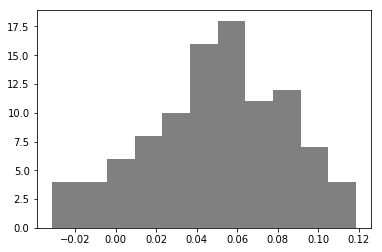

In [92]:
# normal distribution plot
plt.hist(diff, bins=11, color='grey')
plt.show()


In [93]:
# selecting times then difference between android and apple user engagement is less than 0
diff < 0

# the difference is less than 0 only 9 times out of 100
# meaning for 91 times android user's engagement is higher than apple ones


array([False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

### Devices

In [94]:
# apple users average age
df_x_apple = df_x[df_x['brands']==0]
np.mean(df_x_apple['age'])


35.402417962003454

In [95]:
# android users average age
df_x_android = df_x[df_x['brands']==1]
np.mean(df_x_android['age'])


35.44428468727534

Mean:  35.402417962003454 
Median:  33.0 
Mode:  27


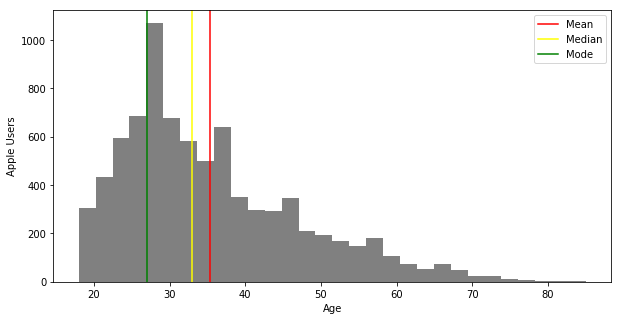

In [96]:
# overall age distribution of apple users
age_apple = df_x_apple['age']

mean = age_apple.mean()
median = age_apple.median()
mode = age_apple.mode()

print('Mean: ',mean,'\nMedian: ',median,'\nMode: ',mode[0])
plt.figure(figsize=(10,5))
plt.hist(age_apple, bins=30, color='grey')
plt.axvline(mean, color='red', label='Mean')
plt.axvline(median, color='yellow', label='Median')
plt.axvline(mode[0], color='green', label='Mode')
plt.xlabel('Age')
plt.ylabel('Apple Users')
plt.legend()
plt.show()


Mean:  35.44428468727534 
Median:  33.0 
Mode:  27


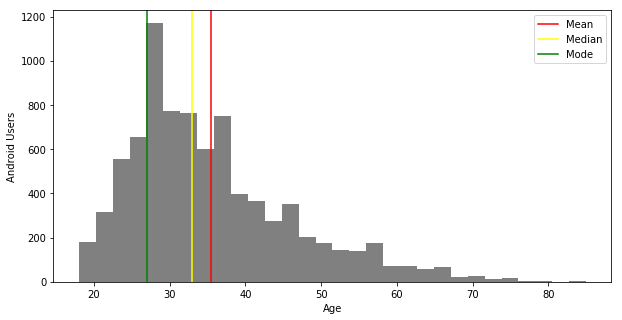

In [97]:
# overall age distribution of android users
age_android = df_x_android['age']

mean = age_android.mean()
median = age_android.median()
mode = age_android.mode()

print('Mean: ',mean,'\nMedian: ',median,'\nMode: ',mode[0])
plt.figure(figsize=(10,5))
plt.hist(age_android, bins=30, color='grey')
plt.axvline(mean, color='red', label='Mean')
plt.axvline(median, color='yellow', label='Median')
plt.axvline(mode[0], color='green', label='Mode')
plt.xlabel('Age')
plt.ylabel('Android Users')
plt.legend()
plt.show()


### Crypto

In [98]:
# filtering only crypto users
df_x_crypto_unlocked = df_x[df_x['user_settings_crypto_unlocked']==1]
df_x_crypto_unlocked.head()


,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
0,1,3,30,0,0,0
2,1,7,27,0,0,0
12,1,0,26,0,0,0
15,1,3,26,0,0,0
39,1,35,27,0,0,0


In [99]:
# separating apple and android users that uses crypto
apples = df_x_crypto_unlocked[df_x_crypto_unlocked['brands']==0]
androids = df_x_crypto_unlocked[df_x_crypto_unlocked['brands']==1]


In [100]:
# average age of apple crypto users
crypto_apple_avg_age = np.mean(apples['age'])
crypto_apple_avg_age


34.19245003700962

In [101]:
# average age of android crypto users
crypto_android_avg_age = np.mean(androids['age'])
crypto_android_avg_age


33.7624703087886

Mean:  33.94382391590013 
Median:  32.0 
Mode:  30


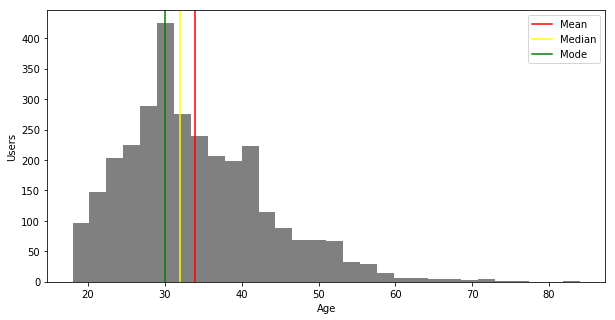

In [102]:
# crypto users age distribution
age = df_x_crypto_unlocked['age']

mean = age.mean()
median = age.median()
mode = age.mode()

print('Mean: ',mean,'\nMedian: ',median,'\nMode: ',mode[0])
plt.figure(figsize=(10,5))
plt.hist(age, bins=30, color='grey')
plt.axvline(mean, color='red', label='Mean')
plt.axvline(median, color='yellow', label='Median')
plt.axvline(mode[0], color='green', label='Mode')
plt.xlabel('Age')
plt.ylabel('Users')
plt.legend()
plt.show()


In [103]:
# average age of overall users
np.mean(df_x['age'])


35.42560805483108

In [104]:
# average age of users that have unlocked crypto
np.mean(df_x_crypto_unlocked['age'])


33.94382391590013

In [105]:
# filtering non-crypto users
df_x_crypto_not_unlocked = df_x[df_x['user_settings_crypto_unlocked']==0]
df_x_crypto_not_unlocked.head()


,user_settings_crypto_unlocked,num_contacts,age,countries,plans,brands
1,0,0,31,0,0,0
3,0,0,48,0,0,0
4,0,0,24,0,0,0
5,0,81,43,0,0,0
6,0,7,28,0,0,0


Mean:  35.76113962657145 
Median:  33.0 
Mode:  27


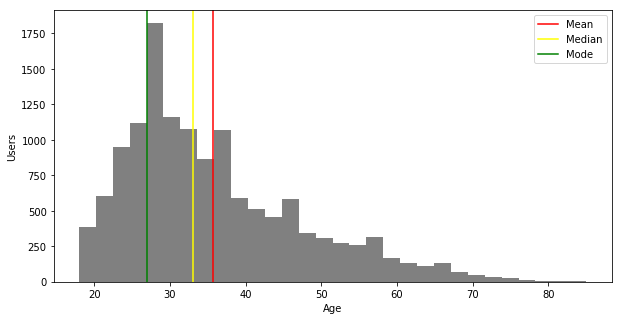

In [106]:
# non-crypto users age distribution
age = df_x_crypto_not_unlocked['age']

mean = age.mean()
median = age.median()
mode = age.mode()

print('Mean: ',mean,'\nMedian: ',median,'\nMode: ',mode[0])
plt.figure(figsize=(10,5))
plt.hist(age, bins=30, color='grey')
plt.axvline(mean, color='red', label='Mean')
plt.axvline(median, color='yellow', label='Median')
plt.axvline(mode[0], color='green', label='Mode')
plt.xlabel('Age')
plt.ylabel('Users')
plt.legend()
plt.show()


In [107]:
# average age of users that have unlocked crypto
np.mean(df_x_crypto_not_unlocked['age'])


35.76113962657145

In [108]:
# apple and android users that have unlocked crypto
df_x_crypto_unlocked['brands'].value_counts()


1    1684
0    1351
2       9
Name: brands, dtype: int64

In [109]:
df_original.head()


,engagement_score,birth_year,country,user_settings_crypto_unlocked,plan,num_contacts,brand,age
0,5.791435,1989,PL,1,STANDARD,3,Apple,30
1,2.306303,1975,GB,0,STANDARD,21,Apple,44
2,14.978079,1980,FR,0,STANDARD,38,Apple,39
3,1.952404,1969,GB,0,STANDARD,0,Apple,50
4,1.600168,1960,GB,1,STANDARD,0,Android,59


In [110]:
# filtering crypto users from original dataframe
df_original_crypto = df_original[df_original['user_settings_crypto_unlocked']==1]
df_original_crypto.head()


,engagement_score,birth_year,country,user_settings_crypto_unlocked,plan,num_contacts,brand,age
0,5.791435,1989,PL,1,STANDARD,3,Apple,30
4,1.600168,1960,GB,1,STANDARD,0,Android,59
17,11.794987,1991,GB,1,STANDARD,8,Android,28
20,1.336663,1985,GB,1,PREMIUM,21,Apple,34
35,11.423368,1982,GG,1,METAL,27,Apple,37


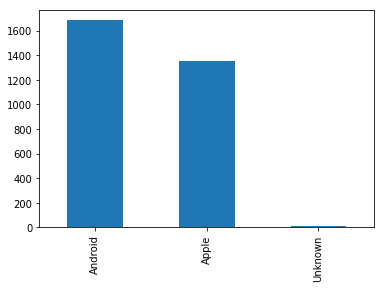

In [111]:
# crypto users device brand chart
fig, ax = plt.subplots()
df_original_crypto['brand'].value_counts().plot(ax=ax, kind='bar')
plt.show()
